In [6]:
!pip uninstall opencv-python -y

Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86


You can safely remove it manually.


In [8]:
!pip install opencv-contrib-python

   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   - -------------------------------------- 1.6/46.2 MB 8.4 MB/s eta 0:00:06
   -- ------------------------------------- 3.4/46.2 MB 8.4 MB/s eta 0:00:06
   ---- ----------------------------------- 5.0/46.2 MB 8.2 MB/s eta 0:00:06
   ----- ---------------------------------- 6.8/46.2 MB 8.2 MB/s eta 0:00:05
   ------- -------------------------------- 8.1/46.2 MB 8.0 MB/s eta 0:00:05
   -------- ------------------------------- 9.4/46.2 MB 7.3 MB/s eta 0:00:06
   --------- ------------------------------ 10.7/46.2 MB 7.4 MB/s eta 0:00:05
   ---------- ----------------------------- 12.3/46.2 MB 7.4 MB/s eta 0:00:05
   ----------- ---------------------------- 13.6/46.2 MB 7.3 MB/s eta 0:00:05
   ------------- -------------------------- 15.2/46.2 MB 7.1 MB/s eta 0:00:05
   -------------- ------------------------- 16.8/46.2 MB 7.2 MB/s eta 0:00:05
   --------------- ------------------------ 18.1/46.2 MB 7.2 MB/s eta 0:00:04



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Total images loaded: 1097
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5464 - loss: 0.9571 - val_accuracy: 0.8591 - val_loss: 0.5143
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8073 - loss: 0.5370 - val_accuracy: 0.8455 - val_loss: 0.3997
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8182 - loss: 0.4396 - val_accuracy: 0.7364 - val_loss: 0.7087
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8187 - loss: 0.4234 - val_accuracy: 0.9091 - val_loss: 0.2251
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8724 - loss: 0.3056 - val_accuracy: 0.9136 - val_loss: 0.2181
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8713 - loss: 0.2781 - val_accuracy: 0.9045 - val_loss: 0.2052
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9121 - loss: 0.2201 - val_accuracy: 0.9136 - val_loss: 0.2104
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8958 - loss: 0.2042 

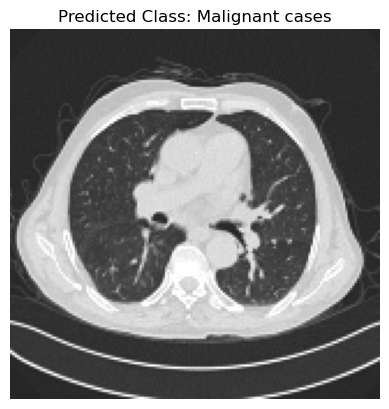

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import os
import random
import cv2
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# from tensorflow.keras.mixed_precision import set_global_policy
# set_global_policy('mixed_float16')

tf.config.optimizer.set_jit(True)

data_dir = r'C:\Users\ayush\CSET301_AI_PROJECT\The IQ-OTHNCCD lung cancer dataset'
img_height, img_width = 160, 160

class_names = ['Normal cases', 'Bengin cases', 'Malignant cases']
images, labels = [], []

for label, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        if not img_name.lower().endswith(('png', 'jpg', 'jpeg')):
            continue
        img = image.load_img(img_path, color_mode='grayscale')
        img = image.img_to_array(img)
        img_rgb = np.stack((img.squeeze(),) * 3, axis=-1)
        img_rgb = cv2.resize(img_rgb, (img_height, img_width))
        images.append(img_rgb)
        labels.append(label)

print(f'Total images loaded: {len(images)}')
images = np.array(images) / 255.0
tf.keras.backend.clear_session()
labels = to_categorical(labels, num_classes=len(class_names))

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=30,
                    callbacks=[early_stop])

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc * 100:.2f}%')

random_index = random.randint(0, len(X_test) - 1)
random_image = X_test[random_index]
prediction = model.predict(np.expand_dims(random_image, axis=0))
predicted_class = np.argmax(prediction)

plt.imshow(random_image)
plt.title(f'Predicted Class: {class_names[predicted_class]}')
plt.axis('off')
plt.show()
